# Data description & Problem statement: 
   The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. Please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
* Dataset is imbalanced. The data has 41188 rows and 20 columns.
* This is a classification problem. the classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial XGBoost model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of XGBoost model: Find the best XGBoost model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score:  0.95 
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Bank Marketing/bank data/bank-additional-full.csv', sep=';')

#df.drop('Loan_ID', axis=1, inplace=True)

#L_c=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status' ]
#L_n=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
L_cat=['poutcome', 'job', 'marital', 'education', 'default', 'housing', 'loan', 
       'contact', 'month', 'day_of_week']
L_con=['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed' ]

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


encode_text_index(df, 'y')

for c in L_cat:
    encode_text_index(df, c)
    
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [5]:
X=df.drop(['y'], axis=1)
y=df['y']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# remove_outliers(X_train, y_train, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], thresh=5)

In [6]:
y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [7]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=XGBClassifier(missing=999, scale_pos_weight=36548/4640) 
kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.94687451 0.94381519 0.94086699 0.94676787] 

Accuracy: 0.94 (+/- 0.00)


In [8]:
# Grid-Search for the best model parameters: 

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

X_r, y_r=X_train, y_train
#X_r, y_r = SMOTE(random_state=42).fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)

# We create a sample_weight list for this imbalanced dataset:
from sklearn.utils.class_weight import compute_sample_weight
sw=compute_sample_weight(class_weight='balanced', y=y_r)


from sklearn.model_selection import GridSearchCV
param={'max_depth':[2, 4, 6], 'min_child_weight':[1, 2, 10], 'gamma': [ 0, 0.05, 0.1], 'subsample':[0.7, 1]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(XGBClassifier(missing=999, seed=42), 
                         param, cv=kfold, n_jobs=-1, scoring="roc_auc")
grid_search.fit(X_r, y_r, sample_weight=sw)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
16,8.666987,0.366006,0.222384,0.032211,0,6,10,0.7,"{'gamma': 0, 'max_depth': 6, 'min_child_weight...",0.949459,0.945475,0.950193,0.948375,0.002073,1,0.968277,0.969468,0.968684,0.968810,0.000494
34,9.359594,0.351893,0.223034,0.009184,0.05,6,10,0.7,"{'gamma': 0.05, 'max_depth': 6, 'min_child_wei...",0.949461,0.945619,0.949869,0.948316,0.001915,2,0.968806,0.969774,0.968417,0.968999,0.000570
52,8.007673,0.316372,0.239934,0.050398,0.1,6,10,0.7,"{'gamma': 0.1, 'max_depth': 6, 'min_child_weig...",0.949091,0.945083,0.950212,0.948129,0.002202,3,0.968511,0.969698,0.968287,0.968832,0.000619


In [9]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, np.array(y_test)),2))

Best parameters:  {'gamma': 0, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.7}
Best validation accuracy:  0.95 (+/- 0.00)
Test score:  0.95


Confusion matrix, without normalization
[[7907 1230]
 [  74 1086]]
Normalized confusion matrix
[[0.87 0.13]
 [0.06 0.94]]


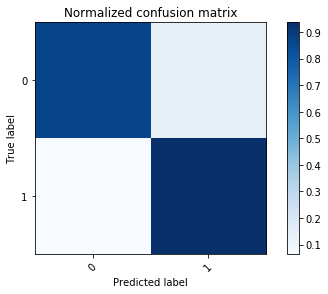

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

In [11]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.99      0.87      0.92      9137
          1       0.47      0.94      0.62      1160

avg / total       0.93      0.87      0.89     10297



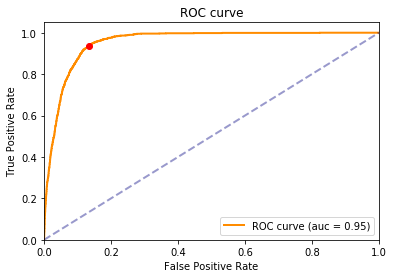

In [12]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

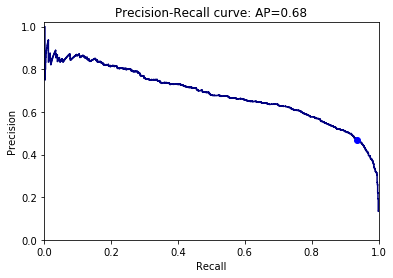

In [13]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(X_test)[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(X_test)[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()

('duration', 0.24752147)
('euribor3m', 0.177462)
('age', 0.10013219)
('day_of_week', 0.051222738)
('education', 0.043621942)
('cons.conf.idx', 0.042961005)
('campaign', 0.042300068)
('cons.price.idx', 0.042300068)
('month', 0.04130866)
('job', 0.03701256)
('emp.var.rate', 0.03536021)
('pdays', 0.031064112)
('nr.employed', 0.019497687)
('poutcome', 0.01817581)
('contact', 0.015201586)
('housing', 0.014871117)
('previous', 0.013879709)
('marital', 0.010575017)
('default', 0.007931262)
('loan', 0.007600793)


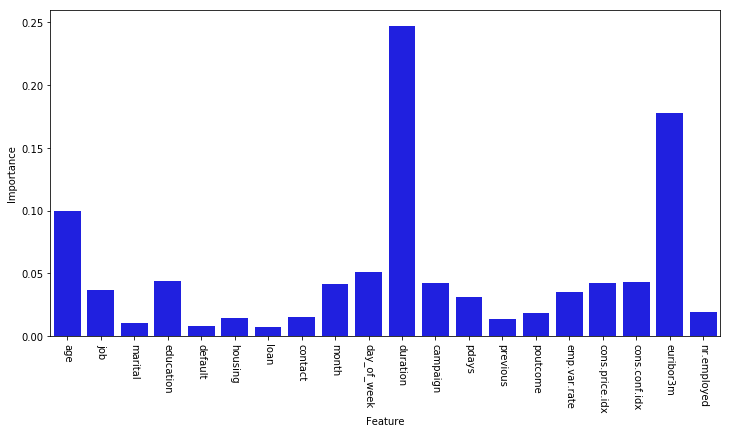

In [14]:
# Feature Importance:
im=XGBClassifier(**grid_search.best_params_).fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns[0:]),columns=["Feature"])

fig, ax = plt.subplots(figsize=(12,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-90)

plt.show()